In [21]:
#this is final one from spring 2022 

import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

%matplotlib inline

In [22]:
#Set grid parameters
num_rows = 100
num_columns = 100
node_spacing = 10.00
node_next_to_outlet = num_columns + 1
outlet_node = 0 

#Set Model Time Parameters
timestep = 100.0
run_time = 5000 #years

uplift_rate = .002 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
mg.status_at_node[outlet_node] = mg.BC_NODE_IS_FIXED_VALUE



#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][:] = 0 #meters 



#topographic roughness
#random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid

#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation' 
#when u change spacing high

mg.at_node["bedrock__elevation"] += (mg.node_y * .00001 + mg.node_x * .00001 + np.random.rand(len(mg.node_y)) / 100) #cm scale rn 
mg.at_node['bedrock__elevation'][outlet_node] = 0 # do this before the mg.at node stuff above

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')
mg.at_node["topographic__elevation"][:] += mg.at_node["bedrock__elevation"]# + mg.at_node['soil__depth'][:]
mg.at_node["bedrock__elevation"][:] += mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#mg.at_node['bedrock__elevation'][outlet_node] = 1 # do this before the mg.at node stuff above
#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)


mg.at_node['topographic__elevation'][outlet_node] = 0
mg.at_node['soil__depth'][outlet_node] = 0
print(outlet_node)





0


In [23]:
#Parameters for SPACE and Fastscape
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001 # depends on size of spatial scale #doubles it from .00001 to get it quicker
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)  

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)

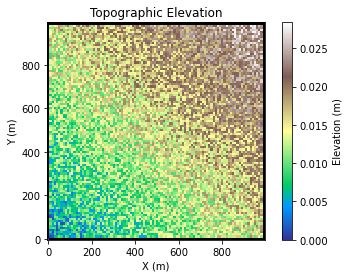

In [24]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [25]:
#run for 10 years
for x in range(100):
    #core nodes are anything except outer boundary
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    #DONT ADD MG.CORE_NODES OR : AFTER TOPO ELEVATION
    #mg.at_node["topographic__elevation"][0]-= 0.001 # Uplift
    #mg.at_node["bedrock__elevation"][0]-= 0.001 # Uplift

    if x ==1000:
        figelev = plt.figure()
        plot = plt.subplot()
        imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
    fa.run_one_step()
    df.map_depressions()
    fsc.run_one_step(100)
    print(x)

    #looks like runtime is 1 minute every 10,000 years (or 100 x) with kbr = .00002

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


20.0276667873
20.0283785436
0.0


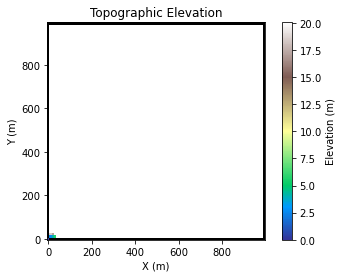

In [26]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

print(np.max(mg.at_node['topographic__elevation'][mg.core_nodes]))

print(np.max(mg.at_node['bedrock__elevation'][mg.core_nodes]))

print(np.max(mg.at_node['soil__depth'][mg.core_nodes]))

prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

#Show the profile
plt.figure(1)
title_text = f"Main Channel Profile"
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)

In [27]:
#Set elapsed time to zero
elapsed_time = 0

#Set timestep count to zero
count = 0
timestep = 10
run_time = 1000 #orig 250000
#Array to save sediment flux values and is currently filled with 0s
sed_flux = [0] * int(run_time/timestep) 
uplift_array = [0] * int(run_time/timestep)

uplift_interval = np.arange(50000,150000, 1) #when the uplift occurs

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    if elapsed_time in uplift_interval:#this is when to double the uplift rate
      uplift_rate = .005 # uplift rate (m/yr)
      uplift_per_timestep = uplift_rate * timestep #amount of uplift per timestep to be added
    else:
      uplift_rate = .001 # uplift rate (m/yr)
      uplift_per_timestep = uplift_rate * timestep #amount of uplift per timestep to be added

    
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    #here you do the soil/ bedrock weathering 
    
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift

    fr.run_one_step()
    sp.run_one_step(dt = timestep)
    #hillslope before or after sp- orders matters on small timestep and small node spacing

    sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]
    uplift_array[count] = uplift_rate

    elapsed_time += timestep
    print(count)
    count +=1

    #Instantiate figure as an empty plot
    #fig = plt.figure()

    #Instantiate subplot as an empty plot
    #sedfluxplot = plt.subplot()

    #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
    #sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

    #Add axis labels to the plot 
    #sedfluxplot.set_title('Sedimentograph') #title
    #sedfluxplot.set_xlabel('Time [yr]') #x axis label
    #sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label

    #fig.savefig("sed" + str(count) + ".png")
    #plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [28]:
print(uplift_interval[1])

50001


Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

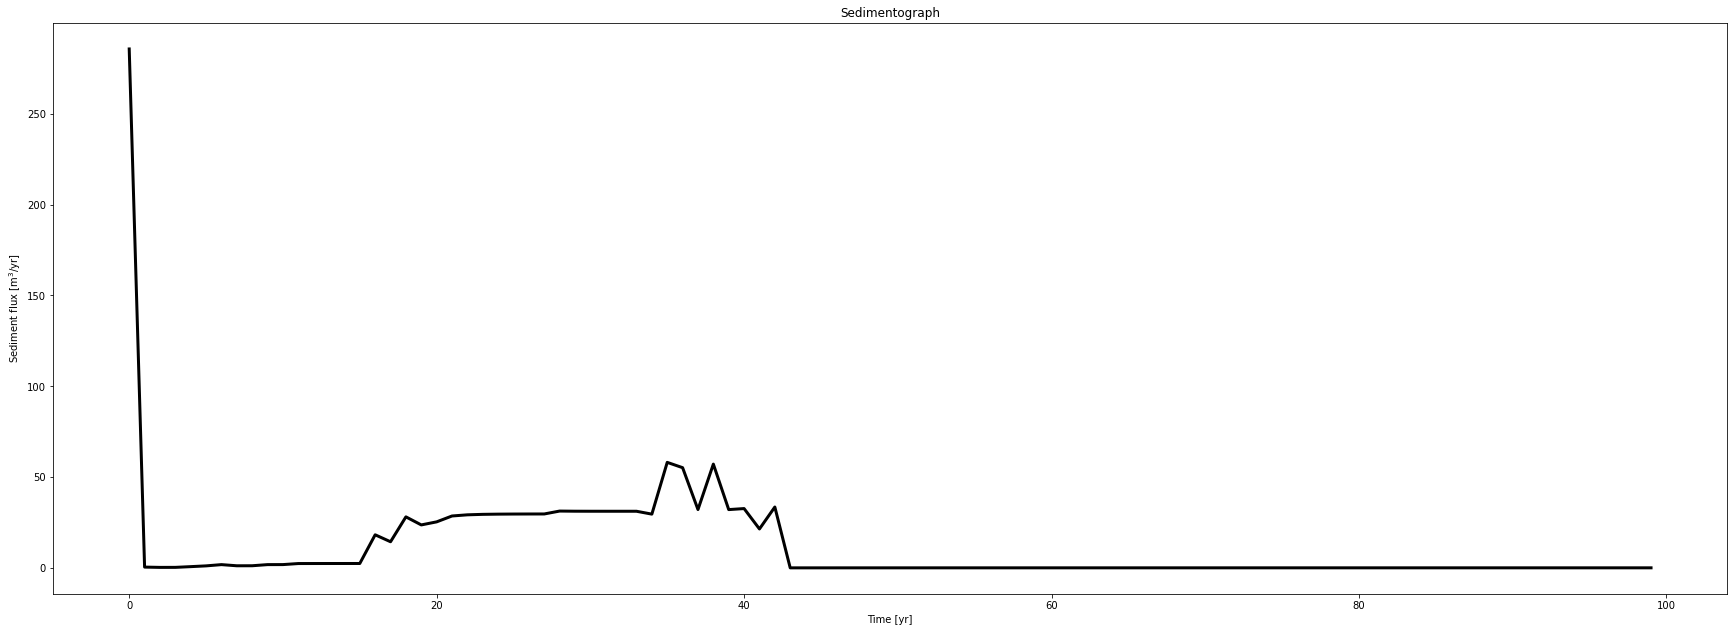

In [29]:

#Instantiate figure as an empty plot
fig = plt.figure()

#Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()
fig.set_size_inches(30, 10.5)
#Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(count),sed_flux, color = 'k', linewidth = 3)

#Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label

In [30]:
prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

#Show the profile
plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)

ValueError: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [ 0.]

In [ ]:
#make uplift plot
fig = plt.figure()

        #Instantiate subplot as an empty plot
uplift_plt = plt.subplot()
fig.set_size_inches(30, 10.5)
        #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running        uplift_plt.plot(np.arange(run_time), uplift_array, color = 'k', linewidth = 3)
uplift_plt.plot(np.arange(count), uplift_array, color = 'k', linewidth = 3)
        #Add axis labels to the plot 
uplift_plt.set_title('Uplift Rate') #title
uplift_plt.set_xlabel('Time [x10$^2$ yr]') #x axis label
uplift_plt.set_ylabel(r'Uplift [x10$^-2$ m$/yr]') #y axis label
#fig.savefig("uplift_images/uplift_" + str(elapsed_time) + ".png")
#plt.close()

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
